In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# some basic imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
import re

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Jordan/Data"

all_data_takaful_and_commercial.dta  Matched_drugs5.csv
choice_drug_not_matched1.csv	     new_choice_drugs.csv
choice_drug_not_matched2.csv	     Not_matched_drugs2.csv
classes.dta			     Not_matched_drugs3.csv
combined_data.dta		     outcome.csv
drug_data.dta			     percentile_scores2.csv
Drug_search.xlsx		     s_stats.csv
Matched_drugs2.gsheet		     unique_drug_freq.csv
Matched_drugs4.csv


In [0]:
#changing the directory to the data directory
%cd /content/drive/My\ Drive/Jordan/Data

/content/drive/My Drive/Jordan/Data


In [0]:
class DataShell:
  def __init__(self):
    self.data_used = "The data used is to evaluate the drug types on Insurance fraud"

  def read_data(self,filename):
    """Reads the data from the current directory
      parameters: filename in the directory
      returns: Dataframe of the data
    """
    self.data = pd.read_stata(filename)
    return self.data

  def sort_data(self,colName,newColName):
    self.temp = self.data[colName].value_counts().to_dict()
    i = 0
    for key in self.temp.keys():
      self.temp[key] = i
      i += 1
    self.data[newColName] = self.data[colName].replace(self.temp)
    return self.data

  def convert_to_datetime(self,column):
    """Converts a column to a datetime object
       parameters:
              column: The column to be converted to a datetime object
       returns: returns the dataframe with the converted column"""
    self.data[column] = pd.to_datetime(self.data[column],errors='coerce')
    return self.data

  def calc_supplydays(self):
    self.data2 = pd.DataFrame(columns=self.data1.columns)
    for nid in self.data1['nid'].unique():
      temp = self.data1[self.data1['nid']==nid].sort_values('visitdate').reset_index(drop=True)
      vis_no = 2
      k1 = pd.DataFrame(temp.visitdate.unique(),columns=['visitdate'])
      k1['days_supply'] = np.nan
      k1['visit_number'] = np.nan
      k1.loc[0,'days_supply'] = 0
      k1.loc[0,'visit_number'] = 1
      for i in range(1,len(k1)):
        k1.loc[i,'days_supply'] = (k1.loc[i,'visitdate']-k1.loc[i-1,'visitdate']).days
        k1.loc[i,'visit_number'] = vis_no
        vis_no += 1
      temp = pd.merge(temp,k1,on='visitdate')
      self.data2 = self.data2.append(temp)
    return self.data2

  def filter_icdcodes(self,reg):
    rex = re.compile(reg)
    newlist = list(filter(rex.match,list(self.data.icd9code)))
    self.data1 = self.data[self.data['icd9code'].isin(newlist)]
    return self.data1

  def cost_per_day(self):
    self.data2['cost_per_day'] = self.data2['claimedvalue']/self.data2['visit_number']
    return self.data2

  def sort_by_clss(self):
    self.data2 = self.data2[self.data2['class']!='']
    self.data2['AV_2'] = np.nan
    self.data3 = pd.DataFrame(columns=self.data2.columns)
    for cov in self.data2['class'].unique():
      temp = self.data2[self.data2['class']==cov]
      temp['AV_2'] = sum(temp['coinsurance'])/sum(temp['claimedvalue'])
      self.data3 = self.data3.append(temp)
    return self.data3

  def sort_hcp(self):
    self.data3 = self.data3[self.data3['hcptype'] == 'Pharmacy']
    return self.data3

  def diabetes_drug_freq(self):
    choicedrug_dict = self.data3.claimeditem.value_counts().to_dict()
    self.df = pd.DataFrame(data=choicedrug_dict,index = [0])
    self.df = (self.df.T)
    self.df['Drugs'] = self.df.index
    self.df.columns=['Frequency','Drugs']
    self.df = self.df.reset_index(drop=True)


  def read_search_drugs(self,file):
    self.drug_search = pd.read_excel(file)

  def match_search_drugs(self):
    self.drug_search['Drugs Matched'] = [list() for y in range(len(self.drug_search.index))]
    self.drug_search['Total Frequency'] = 0
    self.drugs_not_matched = pd.DataFrame(columns=['Drugs','Frequency'])
    for i in range(len(self.df)):
      match = 0
      for choice_drug in range(len(self.drug_search)):
        x = self.drug_search.loc[choice_drug,'Drug'].split()
        counter = 0
        for ik in range(len(x)):
          if x[ik].lower() in self.df.loc[i,'Drugs'].lower():
            counter += 1
        if counter == len(x):
          self.drug_search.loc[choice_drug,'Drugs Matched'].append(self.df.loc[i,'Drugs'])
          self.drug_search.loc[choice_drug,'Total Frequency'] += self.df.loc[i,'Frequency']
          match += 1
      if match == 0:
        self.drugs_not_matched = self.drugs_not_matched.append({'Drugs':self.df.loc[i,'Drugs'],'Frequency':self.df.loc[i,'Frequency']},ignore_index=True)
    for m in range(len(self.drug_search)):
      self.drug_search.loc[m,'Drugs Matched'] = ','.join(self.drug_search.loc[m,'Drugs Matched'])
    return self.drug_search,self.drugs_not_matched

  def switch_item(self):
    self.data3['switch_item'] = np.nan
    self.data4 = pd.DataFrame(columns=self.data3.columns)
    for nid in self.data3.nid.unique():
      k=self.data3[self.data3['nid']==nid].reset_index(drop=True)
      k1= k[k['visit_number']==1.0].reset_index(drop=True)
      lst = []
      for i in range(len(k1)):
        lst.append(k1.loc[i,'claimeditem'])
      for j in range(len(k)):
        if k.loc[j,'visit_number'] == 1.0:
          k.loc[j,'switch_item'] = 0
        else:
          if k.loc[j,'claimeditem'] in lst:
            k.loc[j,'switch_item'] = 0
          else:
            k.loc[j,'switch_item'] = 1
      self.data4 = self.data4.append(k)
    self.data4.reset_index(drop=True,inplace=True)
    return self.data4

  def match_drugs(self):
    self.drug_search_sort = self.drug_search.sort_values('Total Frequency',ascending=False)
    self.drug_search_sort.reset_index(drop=True,inplace=True)
    self.drug_search_mod = self.drug_search_sort.loc[:19,:]
    self.drug_cols = [self.drug_search_mod.loc[i,'Drug'] for i in range(len(self.drug_search_mod))]
    self.one_hot = pd.DataFrame(0,index=range(len(self.data4)),columns=self.drug_cols)
    self.data5 = pd.concat([self.data4,self.one_hot],axis=1)
    for i in range(len(self.data5)):
      for j in range(len(self.drug_search_mod)):
        if (self.data5.loc[i,'claimeditem'] in self.drug_search_mod.loc[j,'Drugs Matched'].split(',')):
          self.data5.loc[i,self.drug_search_mod.loc[j,'Drug']] = 1
          break
    return self.data5

  def outcome(self):
    self.outcome=pd.DataFrame(0,index=range(len(self.data5)),columns=['Outcome'])
    for i in range(len(self.data5)):
      for j in range(len(self.drug_cols)):
        self.outcome.loc[i,'Outcome'] += self.data5.loc[i,self.drug_cols[j]]
    self.data5 = pd.concat([self.data5,self.outcome],axis=1)
    self.data5['OOP'] = self.data5['copay']+self.data5['coinsurance']
    return self.data5

  def summary_stats(self,col):
    l=[]
    for doc in self.data5[col].unique():
      temp = self.data5[self.data5[col]==doc]
      l.append(len(temp))
    mn = np.mean(l)
    md = np.median(l)
    return mn,md,len(l)

  def plot_population_boxplots(self,col):
    my_dict = {}
    for drug in range(20):
      temp = self.data5[self.data5[self.drug_cols[drug]]==1]
      my_dict[drug] = list(temp[col])
    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    plt.title('{} over drugs'.format(col))
    plt.ylabel('{}'.format(col))
    plt.xlabel('Drug ID')

  def conditional_population_boxplots(self,col,level,value,label):
    my_dict = {}
    for drug in range(20):
      temp = self.data5[self.data5[self.drug_cols[drug]]==1]
      if level == 'greater':
        my_dict[drug] = list(temp[temp[col]>value][col])
      elif level == 'lesser':
        my_dict[drug] = list(temp[temp[col]<value][col])
      else:
        my_dict[drug] = list(temp[col])
    fig, ax = plt.subplots()
    ax.boxplot(my_dict.values())
    ax.set_xticklabels(my_dict.keys())
    plt.title('{} range for drugs for {}'.format(col,label))
    plt.ylabel('Price')
    plt.xlabel('Drug ID')

  def conditional_population_histogram(self,col,level,value,label):
    my_dict = {}
    for drug in range(20):
      temp = self.data5[self.data5[self.drug_cols[drug]]==1]
      if level == 'greater':
        my_dict[drug] = len(temp[temp[col]>value])
      elif level == 'lesser':
        my_dict[drug] = len(temp[temp[col]<value])
      else:
        my_dict[drug] = len(temp)
    plt.bar(range(len(my_dict)),list(my_dict.values()),align='center')
    plt.xticks(range(len(my_dict)), list(my_dict.keys()))
    #plt.bar(list(my_dict.keys()), my_dict.values(), color='g')
    plt.title('Number of times drug was prescribed for {}'.format(label))
    plt.ylabel('Frequency')
    plt.xlabel('Drug ID')






In [0]:
data_shell = DataShell()
data = data_shell.read_data('drug_data.dta')
#data.head()
print("The data has ",data.shape[0]," rows and ",data.shape[1]," atrributes")

The data has  605037  rows and  67  atrributes


In [0]:
data = data_shell.convert_to_datetime('visitdate')
data1 = data_shell.filter_icdcodes('25.')
#data1.head()
data1.shape

(11082, 67)

In [0]:
data2 = data_shell.calc_supplydays()
data2 = data_shell.cost_per_day()
#data2.head()

In [0]:
data3 = data_shell.sort_by_clss()
#data3.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [0]:
data3 = data_shell.sort_hcp()
#data3.shape

In [0]:
data_shell.diabetes_drug_freq()
data_shell.read_search_drugs('Drug_search.xlsx')
drug_search,drugs_not_matched = data_shell.match_search_drugs()

In [0]:
choice_drug_not_matched = (drug_search[drug_search['Total Frequency'] == 0]).reset_index(drop=True)
choice_drug_not_matched.head()

,Drug,Market Cost,Drugs Matched,Total Frequency
0,Tresiba Flex Touch Insulin,77.11,,0
1,Toujeo Solostar,48.79,,0
2,Ryzodeg Flex,92.27,,0
3,Synjardy,41.78,,0
4,Glyxambi,57.43,,0


In [0]:
#drug_search.to_csv('Matched_drugs5.csv')
#drugs_not_matched.to_csv('Not_matched_drugs3.csv')
#choice_drug_not_matched.to_csv('choice_drug_not_matched2.csv')

In [0]:
data4 = data_shell.switch_item()
#data4.tail()

In [0]:
#data_shell.drug_search_mod.to_csv('new_choice_drugs.csv')

In [0]:
data5 = data_shell.match_drugs()
data5 = data_shell.outcome()
#data5.head()

In [0]:
phy_mn,phy_md,phy_len = data_shell.summary_stats('hcpid')
nid_mn,nid_md,nid_len = data_shell.summary_stats('nid')

In [0]:
data5.head(n=2)

,nid,hofid,claimid,policyid,claimeditem,claimedvalue,coinsurance,rejected,duevalue,icd9code,class,visitdate,dateclaim,hcpid,hcpcode,hcptype,hcpname,copay,cost,debit,coverage_type,visitdate1,file_days,datereceived,datereceived1,processdate1,fraudster,age,dob,dob1,age1,enroldate1,description,gender,maritalstatus,enroldate,effictivedate,expirydate,days,status,...,_merge,ICD9_chapter,ICD9_cat,provider_type,fraud_side,process_type,rejectedclaim,fully_rejected,rjected_Bin,full_covered,adjusted_claims,settle_days,fraudulent_claims,days_supply,visit_number,cost_per_day,AV_2,switch_item,Glucophage,Galvusmet,Lantus Solostar,Amaryl,Novo Fine Needle,Janumet,Diamicron MR,Metforal,Neurobion tablet,Kombiglyze,Glorion,Apidra Solostar,Galvus 50mg tablet 28's,Januvia,Novorapid,Actos,Glemax,Levemir Flexpen,Novomix,Mixtard 30 HM,Outcome,OOP
0,110.0,110.0,21380580,14315,Glucophage 850mg retard tablet 30's,5.32,0.0,0.054,5.266,250,First,2014-01-03,1/3/2014,6845,6,Pharmacy,Pharmacy One Co,0.054,NaN,0.000,1.0,19783.0,36.0,6/4/2014,19819.0,19827.0,,44.0,18/07/1971,1971-07-18,45.620808,2016-02-05,Head Of Family,Female,Single,5/2/2016,5/2/2016,5/2/2017,366.0,Suspended,...,master only (1),C3,7.0,1.0,NaN,1.0,0.0,0.0,1.0,0.0,1.0,8.0,0.0,0.0,1.0,5.32,0.079602,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.054
1,40002810.0,40002810.0,20842372,10641,Glucophage 850mg retard tablet 30's,5.20,0.0,0.052,5.148,250,First,2013-07-12,7/12/2013,6620,6,Pharmacy,The Islamic Hospital/ Pharmacy/ Except Philade...,0.052,NaN,5.148,1.0,19699.0,37.0,13/01/2014,19736.0,19752.0,,48.0,26/09/1964,1964-09-26,52.427105,2013-02-05,Head Of Family,m,Married,5/2/2013,5/2/2013,5/2/2014,365.0,Suspended,...,master only (1),C3,7.0,1.0,NaN,1.0,0.0,0.0,1.0,0.0,1.0,16.0,0.0,0.0,1.0,5.20,0.079602,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.052


In [0]:
drug_list = data_shell.drug_search_mod
drug_list['DrugID'] = drug_list.index
#drug_list

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


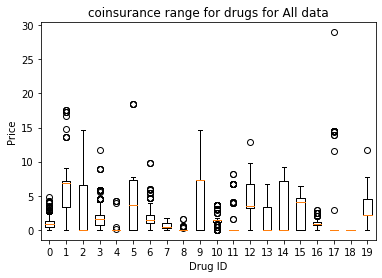

In [0]:
data_shell.conditional_population_boxplots('coinsurance','no level',0,'All data')

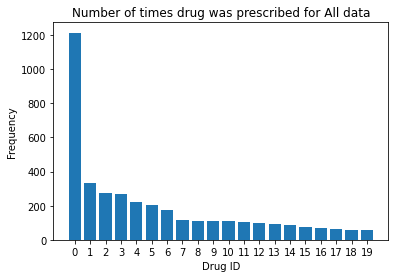

In [0]:
data_shell.conditional_population_histogram('coinsurance','no level',0,'All data')

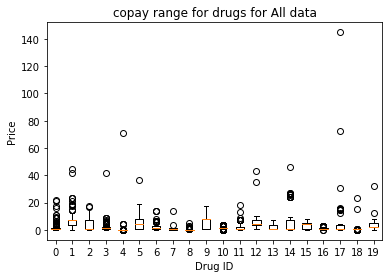

In [0]:
data_shell.conditional_population_boxplots('copay','no level',0,'All data')

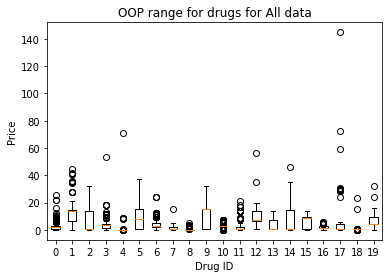

In [0]:
data_shell.conditional_population_boxplots('OOP','no level',0,'All data')

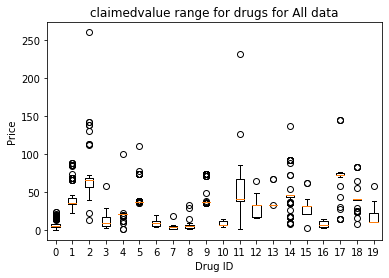

In [0]:
data_shell.conditional_population_boxplots('claimedvalue','no level',0,'All data')

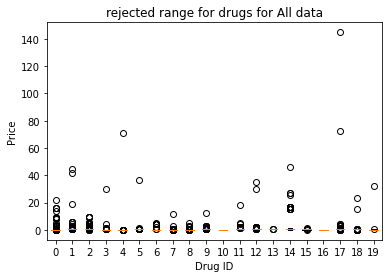

In [0]:
data_shell.conditional_population_boxplots('rejected','no level',0,'All data')

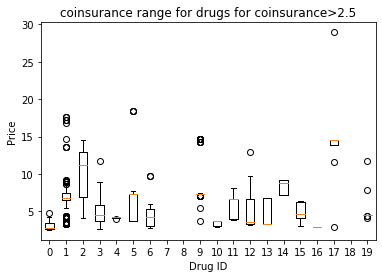

In [0]:
data_shell.conditional_population_boxplots('coinsurance','greater',2.5,'coinsurance>2.5')

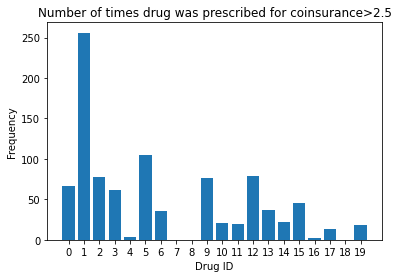

In [0]:
data_shell.conditional_population_histogram('coinsurance','greater',2.5,'coinsurance>2.5')

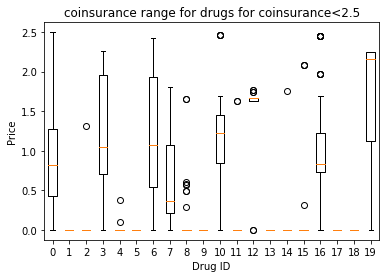

In [0]:
data_shell.conditional_population_boxplots('coinsurance','lesser',2.5,'coinsurance<2.5')

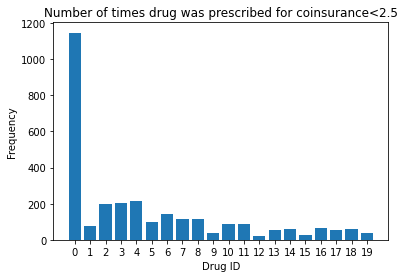

In [0]:
data_shell.conditional_population_histogram('coinsurance','lesser',2.5,'coinsurance<2.5')

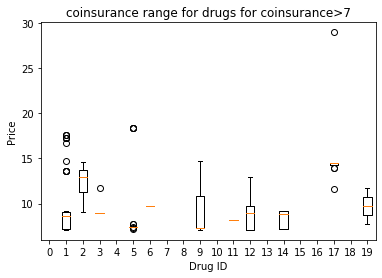

In [0]:
data_shell.conditional_population_boxplots('coinsurance','greater',7,'coinsurance>7')

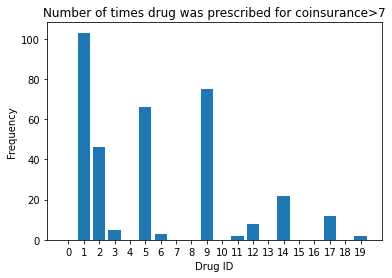

In [0]:
data_shell.conditional_population_histogram('coinsurance','greater',7,'coinsurance>7')

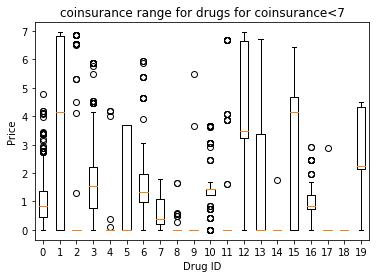

In [0]:
data_shell.conditional_population_boxplots('coinsurance','lesser',7,'coinsurance<7')

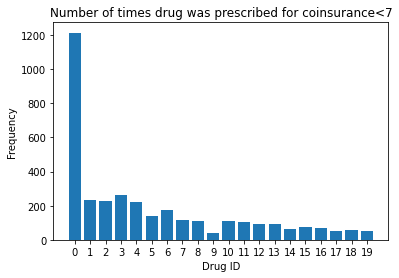

In [0]:
data_shell.conditional_population_histogram('coinsurance','lesser',7,'coinsurance<7')

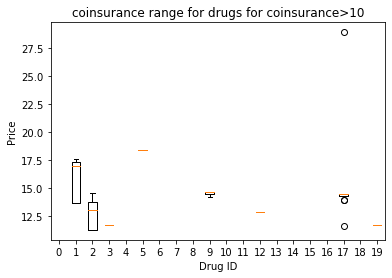

In [0]:
data_shell.conditional_population_boxplots('coinsurance','greater',10,'coinsurance>10')

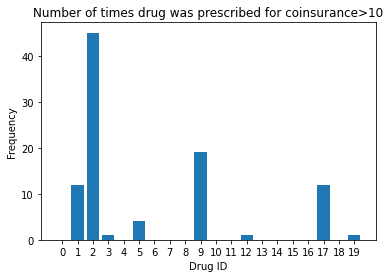

In [0]:
data_shell.conditional_population_histogram('coinsurance','greater',10,'coinsurance>10')

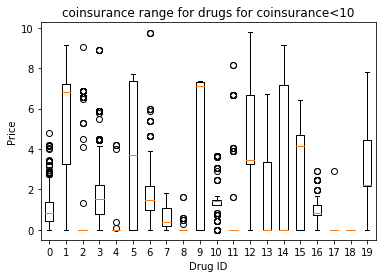

In [0]:
data_shell.conditional_population_boxplots('coinsurance','lesser',10,'coinsurance<10')

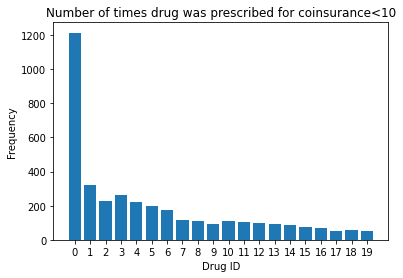

In [0]:
data_shell.conditional_population_histogram('coinsurance','lesser',10,'coinsurance<10')

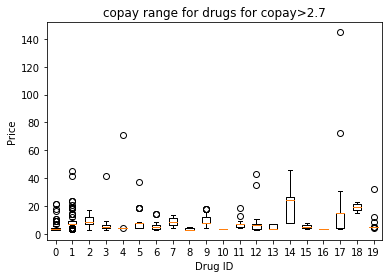

In [0]:
data_shell.conditional_population_boxplots('copay','greater',2.7,'copay>2.7')

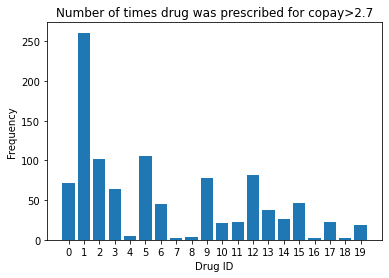

In [0]:
data_shell.conditional_population_histogram('copay','greater',2.7,'copay>2.7')

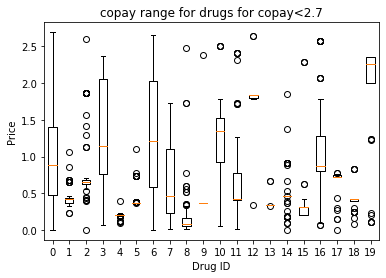

In [0]:
data_shell.conditional_population_boxplots('copay','lesser',2.7,'copay<2.7')

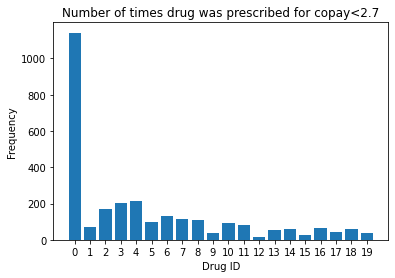

In [0]:
data_shell.conditional_population_histogram('copay','lesser',2.7,'copay<2.7')

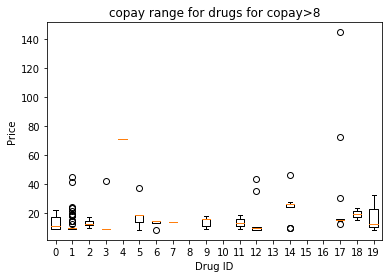

In [0]:
data_shell.conditional_population_boxplots('copay','greater',8,'copay>8')

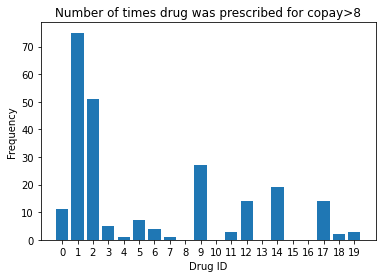

In [0]:
data_shell.conditional_population_histogram('copay','greater',8,'copay>8')

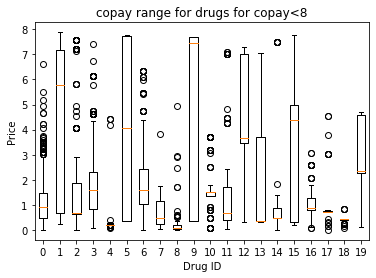

In [0]:
data_shell.conditional_population_boxplots('copay','lesser',8,'copay<8')

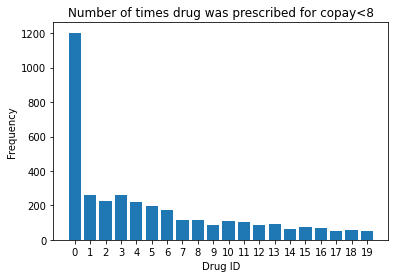

In [0]:
data_shell.conditional_population_histogram('copay','lesser',8,'copay<8')

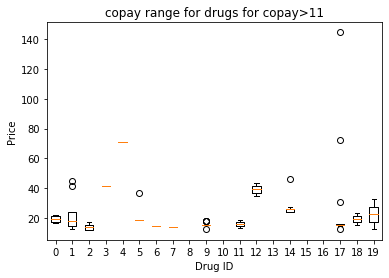

In [0]:
data_shell.conditional_population_boxplots('copay','greater',11,'copay>11')

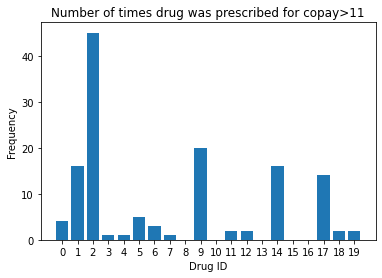

In [0]:
data_shell.conditional_population_histogram('copay','greater',11,'copay>11')

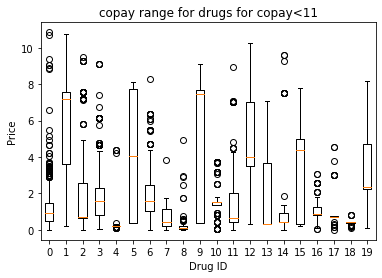

In [0]:
data_shell.conditional_population_boxplots('copay','lesser',11,'copay<11')

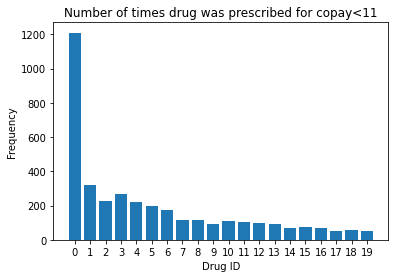

In [0]:
data_shell.conditional_population_histogram('copay','lesser',11,'copay<11')

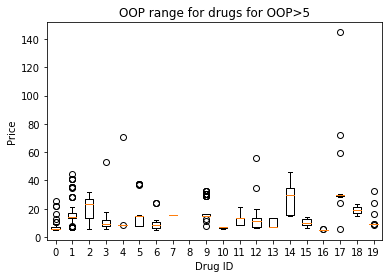

In [0]:
data_shell.conditional_population_boxplots('OOP','greater',5,'OOP>5')

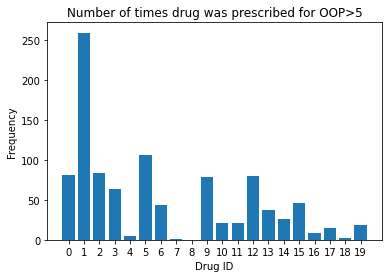

In [0]:
data_shell.conditional_population_histogram('OOP','greater',5,'OOP>5')

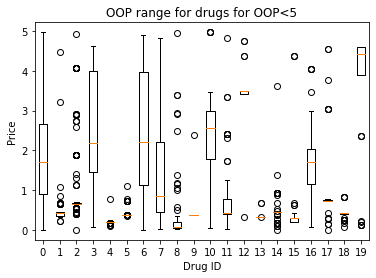

In [0]:
data_shell.conditional_population_boxplots('OOP','lesser',5,'OOP<5')

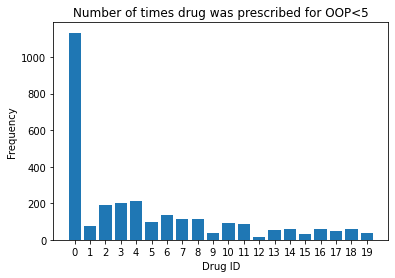

In [0]:
data_shell.conditional_population_histogram('OOP','lesser',5,'OOP<5')

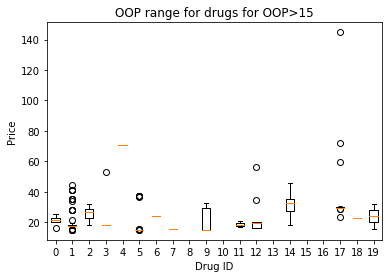

In [0]:
data_shell.conditional_population_boxplots('OOP','greater',15,'OOP>15')

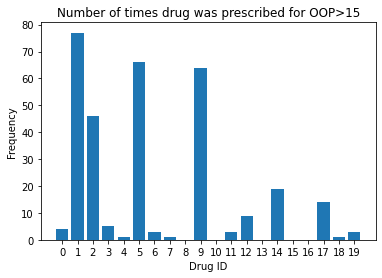

In [0]:
data_shell.conditional_population_histogram('OOP','greater',15,'OOP>15')

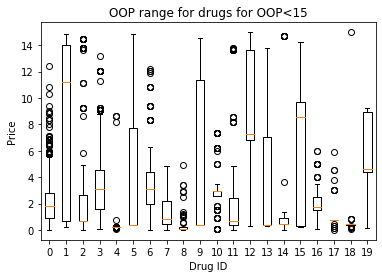

In [0]:
data_shell.conditional_population_boxplots('OOP','lesser',15,'OOP<15')

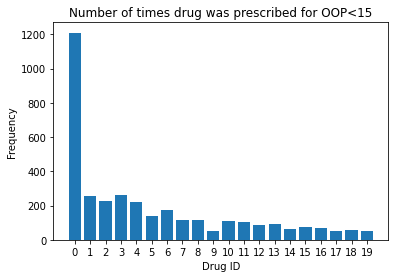

In [0]:
data_shell.conditional_population_histogram('OOP','lesser',15,'OOP<15')

In [0]:
#data5.to_stata('outcome.dta')

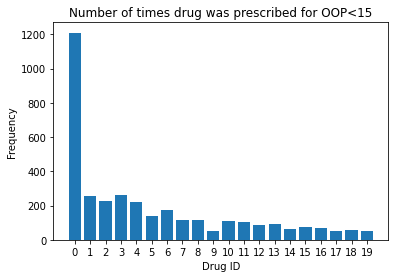

In [0]:
 data_shell.conditional_population_histogram('OOP','lesser',15,'OOP<15')